# Read the Video

In [1]:
import imageio
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (12.0, 9.0)

In [2]:
videoname = 'cornea_video.avi'
video = imageio.get_reader(videoname, 'ffmpeg')
length = video.get_length()
print('Total frames:', length)

Total frames: 139


In [3]:
from skimage.color import rgb2gray

def read_grayed_frame(video, frame_index=0):
    return rgb2gray(video.get_data(frame_index))

## Select two typical frames: `convex` beginning and `concave` midium

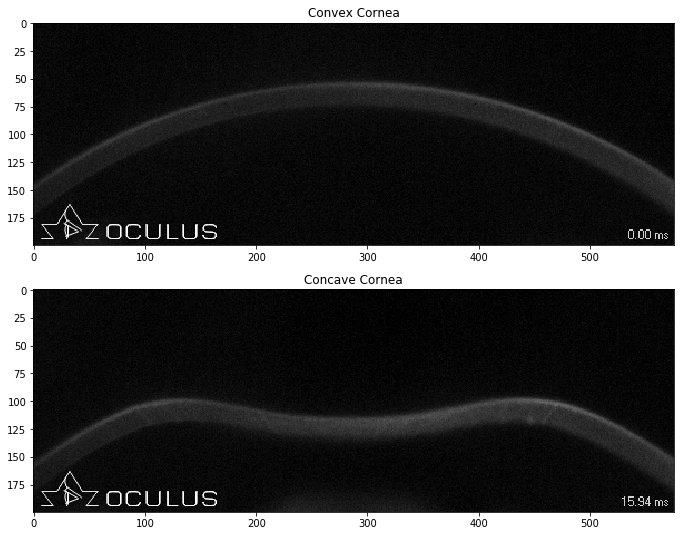

In [4]:
im_convex = read_grayed_frame(video, 0)
im_concave = read_grayed_frame(video, length // 2)

plt.subplot(211)
plt.imshow(im_convex); plt.title('Convex Cornea');
plt.subplot(212)
plt.imshow(im_concave); plt.title('Concave Cornea');

## Remove watermarker

In [5]:
import numpy as np
from skimage.morphology import binary_opening, binary_dilation, binary_closing, disk

### 1. Get dilated mask

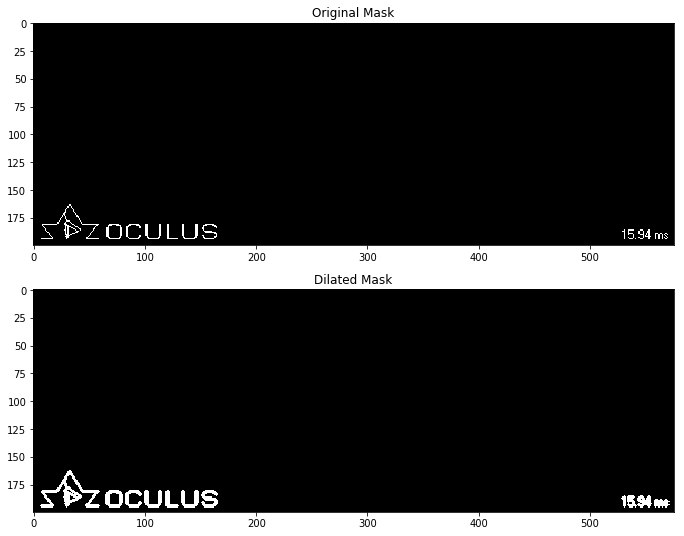

In [6]:
mask_threshold = im_concave > 0.40
mask = binary_dilation(mask_threshold, selem=disk(1))

plt.subplot(211)
plt.imshow(mask_threshold); plt.title('Original Mask');
plt.subplot(212)
plt.imshow(mask); plt.title('Dilated Mask');

### 2. Compute the mask's surrounding intensity for substraction

Surrounding Intensity: 0.0358277243987


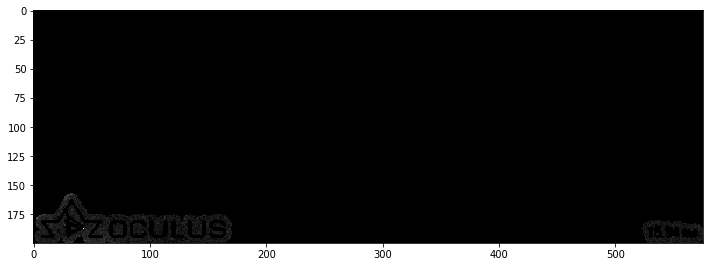

In [7]:
surround_mask = binary_dilation(mask, selem=disk(5)) ^ mask
surround = np.select([surround_mask], [im_concave])
surround_intensity = surround[surround > 0].mean()
plt.imshow(surround)
print('Surrounding Intensity:', surround_intensity)

### 3. Substruct watermarker

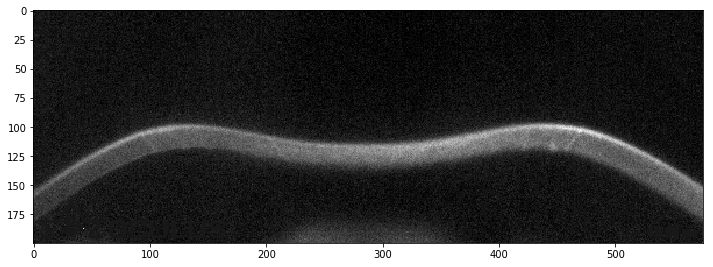

In [8]:
demark = np.select([~mask], [im_concave], default=surround_intensity)
plt.imshow(demark);

### 4. Summarize the preprocess as a function

In [9]:
# mask_threshold = frame > 0.40
# mask = binary_dilation(mask_threshold, selem=disk(1))
# surround_mask = binary_dilation(mask, selem=disk(5)) ^ mask

def preprocess(frame, mask, surround_mask):
    surround = np.select([surround_mask], [frame])
    surround_intensity = surround[surround > 0].mean()
    return np.select([~mask], [frame], default=surround_intensity)

### 5. Check `preprocess` for `im_convex`

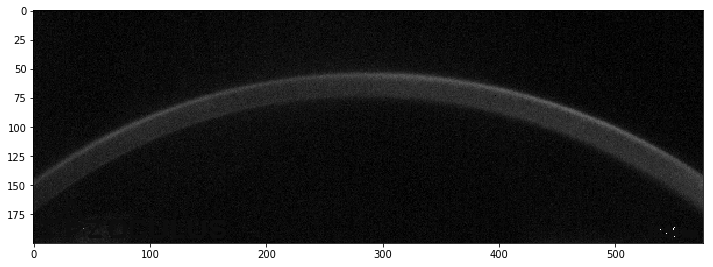

In [10]:
plt.imshow(preprocess(im_convex, mask, surround_mask));

# Segmentation

In [11]:
from skimage.filters import try_all_threshold

## 1. Show all `threshold` method

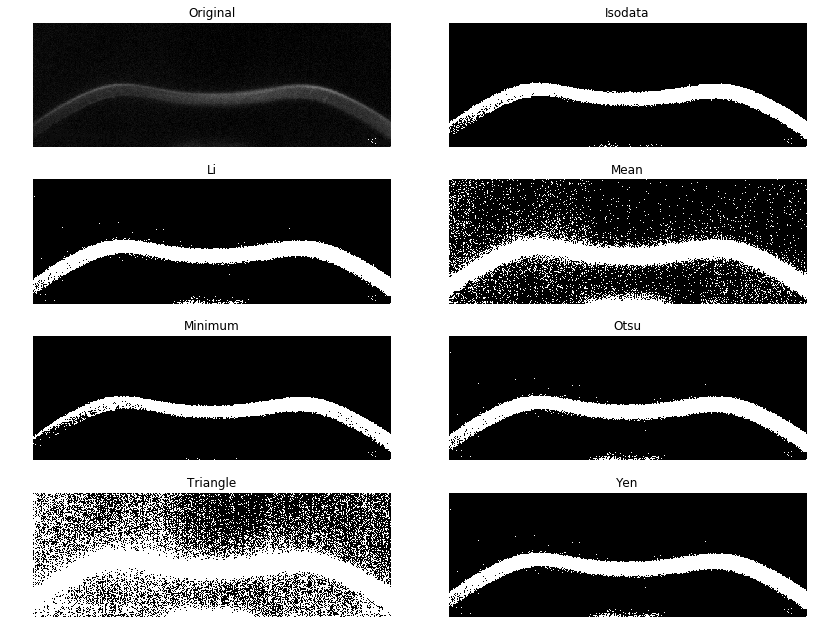

In [12]:
# Read video and select an image, say, 7th image
video = imageio.get_reader('cornea_video.avi', 'ffmpeg')
im = read_grayed_frame(video, 80)
# Remove the watermarker
im = preprocess(im, mask, surround_mask)
# Find the most suitable algorithm to threshold
fig, ax = try_all_threshold(im, figsize=(12, 9), verbose=False)

## 2. Choose `isodata`

In [13]:
from skimage.filters import threshold_isodata

Image threshold: 0.0858915441176


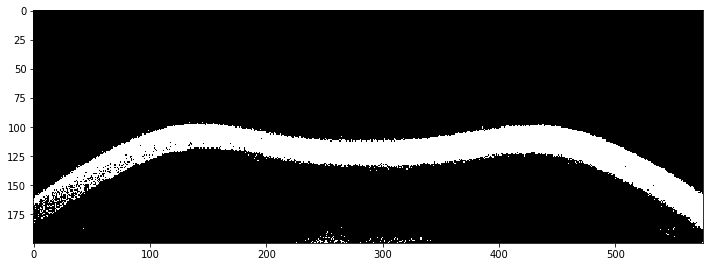

In [14]:
tsh = threshold_isodata(im, nbins=256, return_all=False)
print('Image threshold:', tsh)
bw = im > tsh
plt.imshow(bw);

## 3. Morphological operations

In [15]:
from skimage.morphology import remove_small_objects, remove_small_holes, binary_erosion

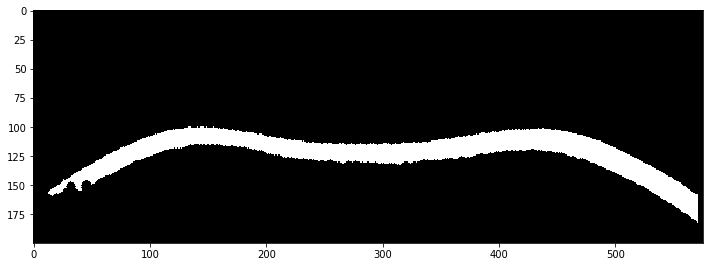

In [16]:
bw = binary_closing(bw, selem=disk(1))
bw = binary_erosion(bw, selem=disk(3))
bw = remove_small_objects(bw, min_size=1024)
plt.imshow(bw)

## 4. Crop the marginal part

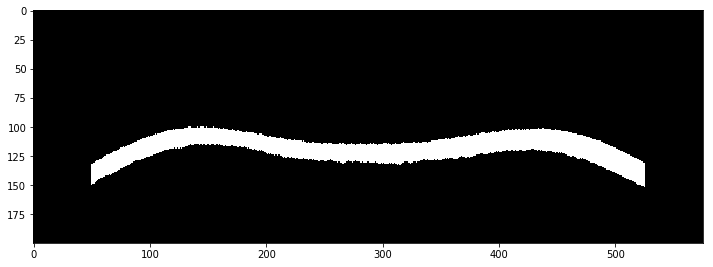

In [17]:
bw[:, :50] = 0
bw[:, -50:] = 0
plt.imshow(bw)

## 5. Find boundary

In [18]:
from skimage.segmentation import find_boundaries

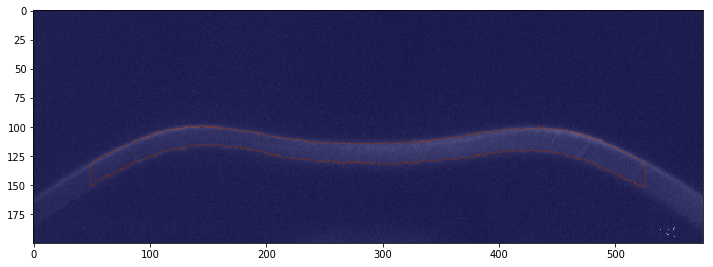

In [19]:
bound = find_boundaries(bw, mode='outer')
plt.imshow(bound, alpha=0.8, cmap='jet')
plt.imshow(im, alpha=0.5)

# Fitting a curve

## 1. Crop the vertical line

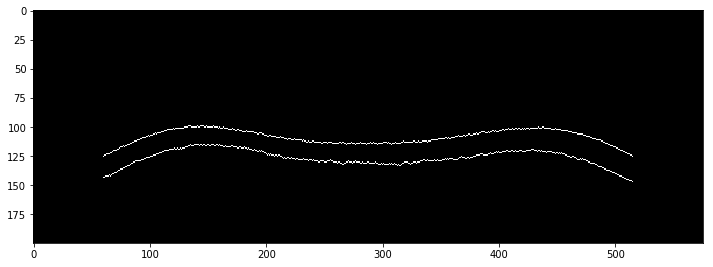

In [20]:
bound[:, :60] = 0
bound[:, -60:] = 0
plt.imshow(bound);

## 2. Separate the upper and lower bound

In [21]:
from skimage.measure import label

In [22]:
labeled_bound = label(bound, connectivity=bound.ndim)
upper, lower = labeled_bound == 1, labeled_bound == 2

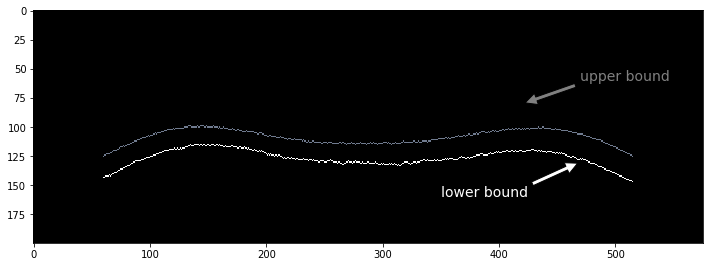

In [23]:
fig = plt.figure();
ax = fig.add_subplot(111)
ax.imshow(labeled_bound, cmap='bone')
ax.annotate('upper bound', xy=(420, 80), xytext=(470, 60), color='gray', size=14,
            arrowprops=dict(facecolor='gray', shrink=0.05),
            )
ax.annotate('lower bound', xy=(470, 130), xytext=(350, 160), color='white', size=14,
            arrowprops=dict(facecolor='white', shrink=0.05),
            )

## 3. Least squares polynomial fit 

In [24]:
f_up, f_lw =  [np.poly1d(np.polyfit(*np.array(np.where(limit))[::-1, ::1], 6)) 
               for limit in [upper, lower]]

In [25]:
y_up, x_up = np.where(upper)
y_lw, x_lw = np.where(lower)

In [26]:
f_up = np.poly1d(np.polyfit(x_up, y_up, 6))
f_lw = np.poly1d(np.polyfit(x_lw, y_lw, 6))

In [27]:
x_cord = range(bound.shape[1])
y_up_fit = f_up(x_cord)
y_lw_fit = f_lw(x_cord)

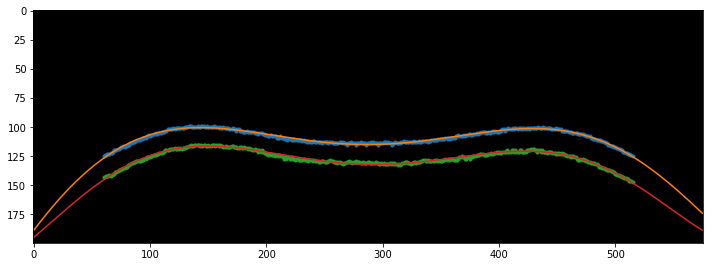

In [28]:
plt.imshow(bound)
plt.plot(x_up, y_up, '.', x_cord, y_up_fit);
plt.plot(x_lw, y_lw, '.', x_cord, y_lw_fit);

## 4. Compute the thickness between `upper` and `lower` bound

In [29]:
thick = abs((y_up_fit - y_lw_fit)[250: 350].mean())
print('Thickness:', thick)

Thickness: 17.2974477504


In [30]:
print('Thickness(Direct substraction):', np.where(upper[:, 300])[0] - np.where(lower[:, 300])[0])

Thickness(Direct substraction): [-18]


# Compose into a function

In [31]:
# Some constant variables
video = imageio.get_reader('cornea_video.avi', 'ffmpeg')
mask_threshold = read_grayed_frame(video, 0) > 0.4
mask = binary_dilation(mask_threshold, selem=disk(1))
surround_mask = binary_dilation(mask, selem=disk(5)) ^ mask
width = mask.shape[1]


def threshold_roi(im_init, left_col=50, right_col=width - 50):
    # Remove the watermarker
    im = preprocess(im_init, mask, surround_mask)
    # Threshold 
    tsh = threshold_isodata(im, nbins=256, return_all=False)
    bw = im > tsh
    bw = binary_closing(bw, selem=disk(1))
    bw = binary_erosion(bw, selem=disk(3))
    bw = remove_small_objects(bw, min_size=1024)
    # Crop marginal parts in case noise
    bw[:, :left_col] = 0; bw[:, right_col:] = 0
    return bw

def compute_thickness(frame_index, show_results=False):
    # Read images
    im_init = read_grayed_frame(video, frame_index)
    bw = threshold_roi(im_init)
    # Find boundaries
    bound = find_boundaries(bw, mode='outer')
    # Remove both vertical side lines
    bound[:, :60] = 0; bound[:, -60:] = 0
    labeled_bound = label(bound, connectivity=bound.ndim)
    # Separate two bounds
    upper, lower = labeled_bound == 1, labeled_bound == 2
    # (1) `::-1` for swap x, y axis
    # (2) `::5` for sample points at step 5
    f_up, f_lw =  [np.poly1d(np.polyfit(np.where(limit)[1], np.where(limit)[0], 6)) 
                   for limit in [upper, lower]]
    # Interpolation
    x_cord = range(width)
    y_up_fit, y_lw_fit = [f(x_cord) for f in [f_up, f_lw]]
    
    vertical_dist = (y_up_fit - y_lw_fit)[width // 2 - 10 : width // 2 + 10]
    
    # Display results
    if show_results:
        plt.imshow(bound, alpha=0.3)
        plt.imshow(im_init, alpha=0.5, cmap='bone')
        plt.plot(x_cord[60: -60], y_up_fit[60: -60]);
        plt.plot(x_cord[60: -60], y_lw_fit[60: -60]);
    
    return abs(vertical_dist.mean())

# Results

In [32]:
import warnings
warnings.filterwarnings("ignore")

19.398588533749319

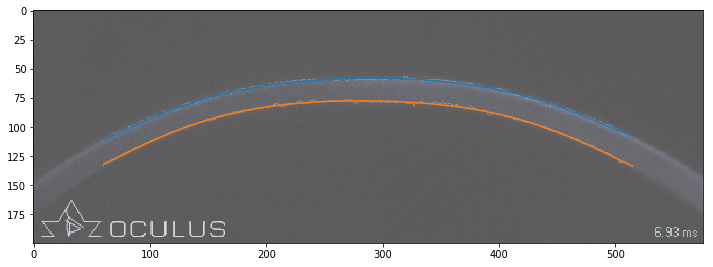

In [33]:
compute_thickness(30, show_results=True)

17.132667399100647

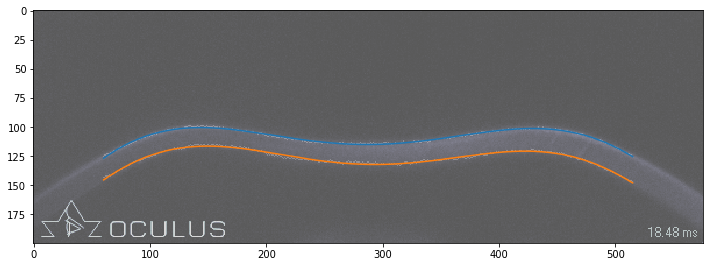

In [34]:
compute_thickness(80, show_results=True)

In [35]:
from tqdm import tqdm
res = []
for i in tqdm(range(video.get_length())):
    res.append(compute_thickness(i))

100%|██████████| 139/139 [00:03<00:00, 46.27it/s]


In [36]:
from scipy.signal import savgol_filter
refined_res = savgol_filter(res, 17, 2)

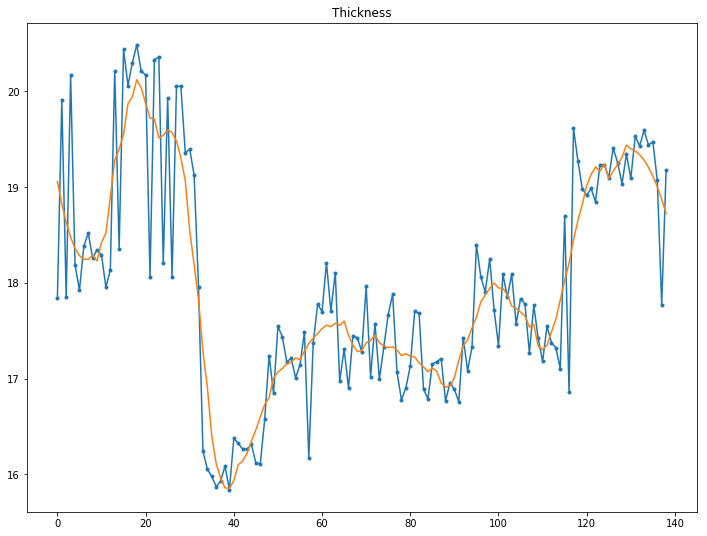

In [37]:
plt.plot(res, '.-')
plt.plot(refined_res)
plt.title('Thickness')

## Get frame interval

In [38]:
def show_time():
    fig, ax = plt.subplots(3, 3, figsize=[6, 6])
    for i in range(9):
        im = read_grayed_frame(video, i)
        ax[i // 3, i % 3].set_title('Index %3d' % i)
        ax[i // 3, i % 3].imshow(im[175:, 530:])
        ax[i // 3, i % 3].axis('off')
    plt.show()

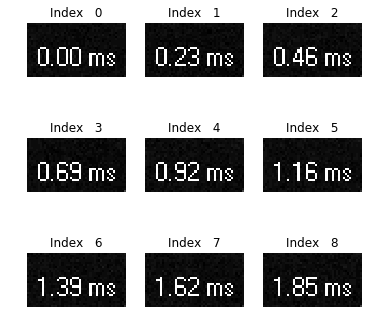

In [39]:
show_time()

### Time interval is `0.23 ms` per frame.

## Replot

In [40]:
x_time = np.arange(len(res)) * 0.23

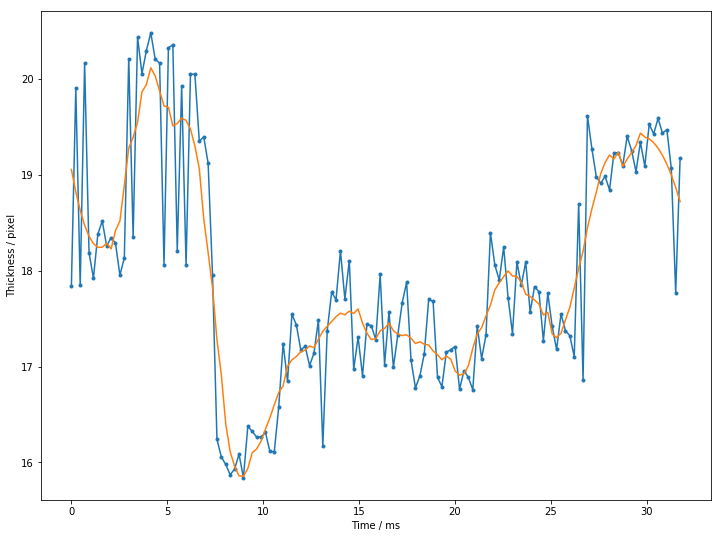

In [41]:
plt.plot(x_time, res, '.-')
plt.plot(x_time, refined_res)
plt.xlabel('Time / ms'); plt.ylabel('Thickness / pixel');

# Vertex Coordinate

In [42]:
from skimage import exposure, filters

In [43]:
video = imageio.get_reader('cornea_video.avi', 'ffmpeg')
im = read_grayed_frame(video, int(16.04 // 0.23))
bw = threshold_roi(im, left_col=400, right_col=width - 30)

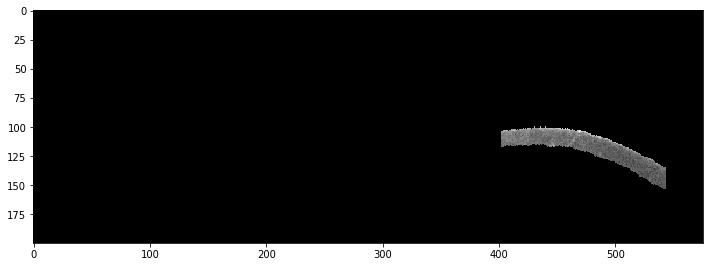

In [44]:
bw = binary_erosion(bw, disk(2))
roi = np.select([bw], [im])
plt.imshow(roi)

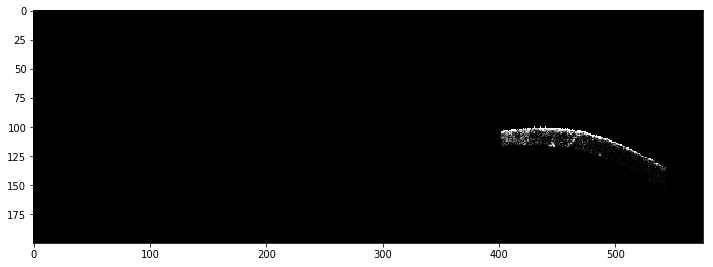

In [45]:
aug = exposure.adjust_sigmoid(roi, cutoff=0.2, gain=70)
plt.imshow(aug)

## `Haar` feature

In [46]:
kernel = np.sum([np.eye(15, 11, k=dist)[::-1] for dist in [0, -1, 1]], axis=0)
kernel *= 100
kernel -= 10
print('The kernel is\n', kernel)

The kernel is
 [[-10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [-10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [-10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.  90.]
 [-10. -10. -10. -10. -10. -10. -10. -10. -10.  90.  90.]
 [-10. -10. -10. -10. -10. -10. -10. -10.  90.  90.  90.]
 [-10. -10. -10. -10. -10. -10. -10.  90.  90.  90. -10.]
 [-10. -10. -10. -10. -10. -10.  90.  90.  90. -10. -10.]
 [-10. -10. -10. -10. -10.  90.  90.  90. -10. -10. -10.]
 [-10. -10. -10. -10.  90.  90.  90. -10. -10. -10. -10.]
 [-10. -10. -10.  90.  90.  90. -10. -10. -10. -10. -10.]
 [-10. -10.  90.  90.  90. -10. -10. -10. -10. -10. -10.]
 [-10.  90.  90.  90. -10. -10. -10. -10. -10. -10. -10.]
 [ 90.  90.  90. -10. -10. -10. -10. -10. -10. -10. -10.]
 [ 90.  90. -10. -10. -10. -10. -10. -10. -10. -10. -10.]]


In [47]:
kernel_shift = np.pad(kernel, [[15, 0], [0, 11]], mode='constant', constant_values=0)
kernel_shift.shape

(30, 22)

In [48]:
from scipy.signal import convolve2d

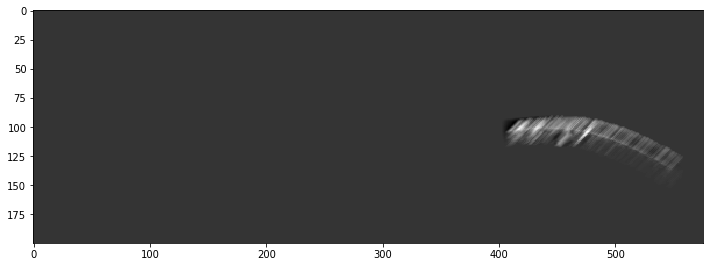

In [49]:
roi_conv = convolve2d(aug, kernel_shift.T, mode='same', boundary='symm')
plt.imshow(roi_conv);

In [50]:
result_r, result_c = np.where(roi_conv == np.max(roi_conv))
print('Result row: %d\tcol: %d' % (result_r, result_c - 7))

Result row: 104	col: 469


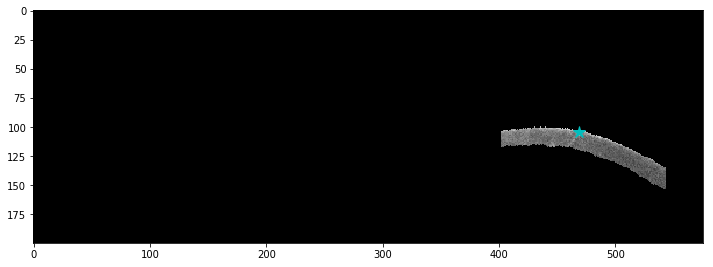

In [51]:
plt.imshow(roi)
plt.plot(result_c - 7, result_r, 'c*', ms=12)

## Compose to a function

In [52]:
from scipy.signal import convolve2d

In [53]:
# 1. Define a kernel as `haar` feature
kernel = np.sum([np.eye(15, 11, k=dist)[::-1] for dist in [0, -1, 1]], axis=0)
kernel *= 100
kernel -= 10
kernel_shift = np.pad(kernel, [[15, 0], [0, 11]], mode='constant', constant_values=0).T
# 2. Read video handle
video = imageio.get_reader('cornea_video.avi', 'ffmpeg')
# 3. Vertex apperas in these time intervals
start_i, end_i = int(12.47 // 0.23), int(21.48 // 0.23)

In [54]:
# 4. A loop to compute coordinates
def find_vertex(kernel=kernel_shift):
    results = []
    for t in tqdm(range(start_i, end_i)):
        im = read_grayed_frame(video, t)
        bw = threshold_roi(im, left_col=400, right_col=width - 30)    
        bw = binary_erosion(bw, disk(2))
        roi = np.select([bw], [im])
        roi_aug = exposure.adjust_sigmoid(roi, cutoff=0.2, gain=70)
        roi_conv = convolve2d(roi_aug, kernel_shift, mode='same', boundary='symm')
        res_r, res_c = np.where(roi_conv == np.max(roi_conv))
        # find valid results
        if results:
            cond = np.array([res_c[-1] < results[-1][1] or abs(res_c[-1] - results[-1][1]) > 3,
                             abs(res_r[-1] - results[-1][0]) > 3])
            while cond.any():
                roi_conv[res_r, res_c] = 0
                res_r, res_c = np.where(roi_conv == np.max(roi_conv))
                cond = np.array([res_c[-1] < results[-1][1] or abs(res_c[-1] - results[-1][1]) > 3,
                                 abs(res_r[-1] - results[-1][0]) > 3])
        
        results.append([res_r, res_c])
    results = np.array(results).squeeze()
    results[:, 0] -= 2
    results[:, 1] -= 6
    return results

In [55]:
results = find_vertex()

100%|██████████| 39/39 [00:10<00:00,  3.29it/s]


In [56]:
from skimage import io

In [57]:
def add_coordinates_in_video():
    video = imageio.get_reader('cornea_video.avi', 'ffmpeg')
    for i in tqdm(range(video.get_length())):
        im = read_grayed_frame(video, i)
        fig = plt.figure()
        plt.imshow(im, 'gray')
        if i in range(start_i, end_i) :
            plt.plot(*results[i - start_i][::-1], 'c+', ms=12)
        plt.axis('off')
        plt.savefig('./results/corena_' + str(i + 1) + '.png', bbox_inches='tight', dpi=im.shape[1])
        plt.close() 

In [58]:
add_coordinates_in_video()

100%|██████████| 139/139 [10:14<00:00,  4.55s/it]


In [59]:
images = [io.imread('./results/corena_' + str(i + 1) + '.png') for i in range(video.get_length())]
imageio.mimwrite('cornea_mark.mp4', images)

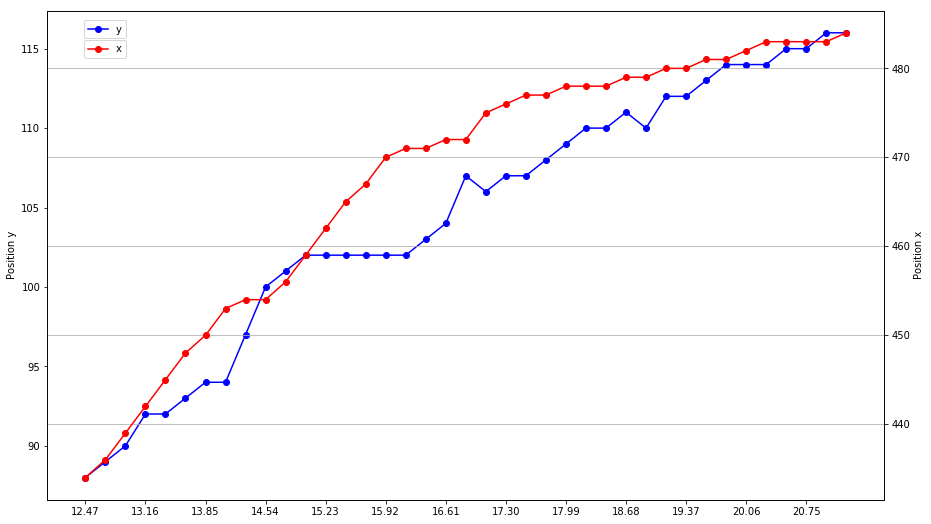

In [60]:
x_cord = np.arange(12.47, 21.44, 0.23)
fig, axis_y = plt.subplots(figsize=[15, 9])
axis_x = axis_y.twinx()
axis_y.plot(x_cord, results[:, 0], 'bo-', label='y')
axis_y.set_ylabel('Position y')
axis_y.set_xticks(x_cord[::3])
axis_y.legend(bbox_to_anchor=(0.1, 0.99))

axis_x.plot(x_cord, results[:, 1], 'ro-', label='x')
axis_x.set_ylabel('Position x')
axis_x.legend(bbox_to_anchor=(0.1, 0.95))
plt.grid('on')

In [64]:
%%HTML
<video width='500' height='240' controls>
  <source src='./resource/cornea_mark.mp4' type="video/mp4">
</video>

# Discussion

1. Also could use `dilation - erosion` to find contours.
2. When computes the vertex coordinates, the presumption of **consecutive** positions may limits method's **generalization** ability.